In [2]:
%load_ext autoreload
%autoreload 2

import keras
from models import TestModels
import data
import moveFiles
import numpy as np
import pandas as pd
import os
from keras.models import load_model, Model
import utils
from utils import NewAccuracy

Using TensorFlow backend.


In [25]:
file_limit = 1000
# train, test, filenames = moveFiles.moveFiles(limit_files=file_limit)
saveMapping = True
loadMapping = False

outputMappingPath = os.path.join("output", "mappings")

if saveMapping == True:
    train, test, filenames = moveFiles.moveFiles(limit_files=file_limit)
#     trainTest = (train, test)
    outputMappingPath = os.path.join('output', 'mappings')
    if not os.path.isdir(outputMappingPath):
        os.makedirs(outputMappingPath)
    train.to_csv(os.path.join(outputMappingPath, 'final1000TRAINMap.csv'))
    test.to_csv(os.path.join(outputMappingPath, 'final1000TESTMap.csv'))
    
if loadMapping == True:
    trainLoaded = pd.read_csv(os.path.join(outputMappingPath, 'TRAINmap.csv'))
    testLoaded = pd.read_csv(os.path.join(outputMappingPath, 'TESTMap.csv'))
#     trainLoaded = pd.read_csv(os.path.join(outputMappingPath, 'vgg_fancy_100files_TRAINMap.csv'))
#     testLoaded = pd.read_csv(os.path.join(outputMappingPath, 'vgg_fancy_100files_TESTMap.csv'))
    moveFiles.moveFiles(trainData = trainLoaded, testData = testLoaded, limit_files=file_limit)

pp = data.Preprocessing()
pp.extractAllVideos()

In [53]:
#extract videos into frames and create CSV file
pp = data.Preprocessing()
pp.extractAllVideos()

In [1]:
# m = TestModels(5, 'newResNet')
# m.model.summary()

In [2]:
dataset = data.DataSet()
dataset.classes
experiment = '2'
# dataset.dumpNumpyFiles(seq_len_limit=20, experiment=experiment)
# x,y,yseq = dataset.all_data_from_npz('train')

In [ ]:
# MAIN LOOP

k_fold = 5
for k in range(0, k_fold):
    # Randomize train and test
    if k > 0:
        moveFiles.randomizeNumpy()
    
    # Train model
    m = TestModels(5, 'newResNet')
    outputEpochPath = os.path.join('output', 'model_checkpoints') 
    if not (os.path.isdir(outputEpochPath)):
        os.makedirs(outputEpochPath)

    filepath = os.path.join(outputEpochPath, "exp{}-2,3,6-k{}.hdf5".format(experiment, k))
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

    gen = data.DataGenerator('train', batch_size = 1, useSequences=True)
    val = data.DataGenerator('test', batch_size = 1, useSequences=True)

    callbacks = [checkpoint]
    m.model.fit_generator(gen, validation_data = val, epochs=50, callbacks=callbacks) 
    
    # Evaluate and save
    path = os.path.join('output', 'model_checkpoints')
    m = load_model(os.path.join(path, "exp{}-2,3,6-k{}.hdf5".format(experiment, k)))
    
    x,y,yseq = dataset.all_data_from_npz('test')
    
    outputCSVPath = os.path.join('output', 'csv') 
    if not (os.path.isdir(outputCSVPath)):
        os.makedirs(outputCSVPath)
    
    if experiment == 'standard':
        tup = utils.nonNormalAccuracy(x,yseq,dataset,m) 
        print(tup[0])
        print(tup[1])
        d = {'Non-Normal Accuracy': {'Acc': tup[0]}, 'Class Accuracy': tup[1]}
        df = pd.DataFrame(data = d)
        df.to_csv(os.path.join(outputCSVPath, "exp{}-19-k{}.csv".format(experiment, k)))
    else:
        tup = utils.nonNormalAccuracy(x,yseq,dataset,m) 
        d = {'Non-Normal Accuracy': {'Acc': tup[0]}}
        df = pd.DataFrame(data = d)
        df.to_csv(os.path.join(outputCSVPath, "exp{}-2,3,6-k{}.csv".format(experiment, k)))

In [4]:
import glob

csv_files = glob.glob(os.path.join(outputCSVPath, '*.csv'))
actualFiles = []
for file in csv_files:
    if "exp{}-2,3,6-k".format(experiment) in file:
        actualFiles.append(file)

# Generate final (averaged) accuracy for current test
if experiment == 'standard':
    acc = []
    normal = []
    black = []
    blurred = []
    insert = []
    compressed = []
    
    for file in actualFiles:
        df = pd.read_csv(file)

        acc.append(df.iloc[0,1])
        normal.append(df.iloc[5,2])
        black.append(df.iloc[1,2])
        blurred.append(df.iloc[2,2])
        insert.append(df.iloc[4,2])
        compressed.append(df.iloc[3,2])
        
    normal = np.mean(normal)
    print("normal: ", normal)
    compressed = np.mean(compressed)
    print("compressed: ", compressed)
    insert = np.mean(insert)
    print("insert: ", insert)
    blurred = np.mean(blurred)
    print("blurred: ", blurred)
    black = np.mean(black)
    print("black: ", black)
    acc = np.mean(acc)
    print("acc: ", acc)
else:
    acc = []
    
    for file in actualFiles:
        df = pd.read_csv(file)

        acc.append(df.iloc[0,1])
        
    acc = np.mean(acc)
    print("acc: ", acc)

            

acc:  0.7684210526315789


In [4]:
tup = utils.nonNormalAccuracy(x,yseq,dataset,m) 
d = {'Non-Normal Accuracy': {'Acc': tup[0]}}
df = pd.DataFrame(data = d)
df.to_csv(os.path.join(outputCSVPath, "exp{}-2,1,1-k{}.csv".format(experiment, k)))

In [8]:
m = TestModels(5, 'newResNet')

outputEpochPath = os.path.join('output', 'model_checkpoints') 

if not (os.path.isdir(outputEpochPath)):
    os.makedirs(outputEpochPath)

filepath = os.path.join(outputEpochPath, "final100resImg-exp3-244Manip-{epoch:02d}-{val_acc:.2f}.hdf5")
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# x,y,yseq = dataset.all_data_from_npz('test')

# c_weights = {0:10, 1:10, 2:10, 3:10, 4:1}
gen = data.DataGenerator('train', batch_size = 1, useSequences=True)
val = data.DataGenerator('test', batch_size = 1, useSequences=True)
# val = data.DataGenerator('test', batch_size =4, useSequences=True, class_weights=c_weights)
# c_weights = {0:10, 1:10, 2:10, 3:10, 4:1}

callbacks = [checkpoint]
# callbacks = [checkpoint, NewAccuracy(x, yseq, dataset)]
m.model.fit_generator(gen, validation_data = val, epochs=50, callbacks=callbacks) 


C:\ANACONDA\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/50
75/75 [==============================] - ETA: 18:34 - loss: 1.5136 - acc: 0.35 - ETA: 9:19 - loss: 1.5484 - acc: 0.3250 - ETA: 6:14 - loss: 1.4907 - acc: 0.400 - ETA: 4:41 - loss: 1.4296 - acc: 0.450 - ETA: 3:45 - loss: 1.4058 - acc: 0.480 - ETA: 3:08 - loss: 1.3777 - acc: 0.500 - ETA: 2:41 - loss: 1.3671 - acc: 0.514 - ETA: 2:21 - loss: 1.3409 - acc: 0.525 - ETA: 2:06 - loss: 1.3196 - acc: 0.533 - ETA: 1:53 - loss: 1.3200 - acc: 0.540 - ETA: 1:43 - loss: 1.2901 - acc: 0.545 - ETA: 1:34 - loss: 1.2822 - acc: 0.550 - ETA: 1:27 - loss: 1.2729 - acc: 0.550 - ETA: 1:20 - loss: 1.2622 - acc: 0.553 - ETA: 1:15 - loss: 1.2492 - acc: 0.556 - ETA: 1:10 - loss: 1.2476 - acc: 0.559 - ETA: 1:05 - loss: 1.2275 - acc: 0.564 - ETA: 1:01 - loss: 1.2177 - acc: 0.566 - ETA: 58s - loss: 1.2068 - acc: 0.565 - ETA: 55s - loss: 1.2010 - acc: 0.56 - ETA: 52s - loss: 1.1810 - acc: 0.57 - ETA: 49s - loss: 1.1684 - acc: 0.57 - ETA: 47s - loss: 1.1704 - acc: 0.57 - ETA: 44s - loss: 1.1624 - acc: 0.57 

75/75 [==============================] - ETA: 21s - loss: 0.0306 - acc: 1.00 - ETA: 21s - loss: 0.0260 - acc: 1.00 - ETA: 20s - loss: 0.0248 - acc: 1.00 - ETA: 20s - loss: 0.0227 - acc: 1.00 - ETA: 20s - loss: 0.0224 - acc: 1.00 - ETA: 20s - loss: 0.0233 - acc: 1.00 - ETA: 19s - loss: 0.0226 - acc: 1.00 - ETA: 19s - loss: 0.0223 - acc: 1.00 - ETA: 19s - loss: 0.0220 - acc: 1.00 - ETA: 18s - loss: 0.0213 - acc: 1.00 - ETA: 18s - loss: 0.0207 - acc: 1.00 - ETA: 18s - loss: 0.0198 - acc: 1.00 - ETA: 18s - loss: 0.0193 - acc: 1.00 - ETA: 17s - loss: 0.0194 - acc: 1.00 - ETA: 17s - loss: 0.0194 - acc: 1.00 - ETA: 17s - loss: 0.0196 - acc: 1.00 - ETA: 16s - loss: 0.0197 - acc: 1.00 - ETA: 16s - loss: 0.0194 - acc: 1.00 - ETA: 16s - loss: 0.0189 - acc: 1.00 - ETA: 16s - loss: 0.0186 - acc: 1.00 - ETA: 15s - loss: 0.0187 - acc: 1.00 - ETA: 15s - loss: 0.0185 - acc: 1.00 - ETA: 15s - loss: 0.0186 - acc: 1.00 - ETA: 14s - loss: 0.0188 - acc: 1.00 - ETA: 14s - loss: 0.0186 - acc: 1.00 - ETA: 14s 

75/75 [==============================] - ETA: 21s - loss: 0.0040 - acc: 1.00 - ETA: 20s - loss: 0.0061 - acc: 1.00 - ETA: 20s - loss: 0.0071 - acc: 1.00 - ETA: 20s - loss: 0.0071 - acc: 1.00 - ETA: 19s - loss: 0.0071 - acc: 1.00 - ETA: 19s - loss: 0.0072 - acc: 1.00 - ETA: 19s - loss: 0.0070 - acc: 1.00 - ETA: 18s - loss: 0.0072 - acc: 1.00 - ETA: 18s - loss: 0.0073 - acc: 1.00 - ETA: 18s - loss: 0.0072 - acc: 1.00 - ETA: 18s - loss: 0.0072 - acc: 1.00 - ETA: 17s - loss: 0.0071 - acc: 1.00 - ETA: 17s - loss: 0.0070 - acc: 1.00 - ETA: 17s - loss: 0.0070 - acc: 1.00 - ETA: 16s - loss: 0.0070 - acc: 1.00 - ETA: 16s - loss: 0.0070 - acc: 1.00 - ETA: 16s - loss: 0.0071 - acc: 1.00 - ETA: 16s - loss: 0.0069 - acc: 1.00 - ETA: 15s - loss: 0.0068 - acc: 1.00 - ETA: 15s - loss: 0.0070 - acc: 1.00 - ETA: 15s - loss: 0.0070 - acc: 1.00 - ETA: 14s - loss: 0.0071 - acc: 1.00 - ETA: 14s - loss: 0.0070 - acc: 1.00 - ETA: 14s - loss: 0.0069 - acc: 1.00 - ETA: 14s - loss: 0.0069 - acc: 1.00 - ETA: 13s 

75/75 [==============================] - ETA: 20s - loss: 0.0040 - acc: 1.00 - ETA: 20s - loss: 0.0034 - acc: 1.00 - ETA: 20s - loss: 0.0037 - acc: 1.00 - ETA: 20s - loss: 0.0035 - acc: 1.00 - ETA: 19s - loss: 0.0036 - acc: 1.00 - ETA: 19s - loss: 0.0039 - acc: 1.00 - ETA: 19s - loss: 0.0038 - acc: 1.00 - ETA: 19s - loss: 0.0042 - acc: 1.00 - ETA: 18s - loss: 0.0041 - acc: 1.00 - ETA: 18s - loss: 0.0041 - acc: 1.00 - ETA: 18s - loss: 0.0040 - acc: 1.00 - ETA: 17s - loss: 0.0039 - acc: 1.00 - ETA: 17s - loss: 0.0040 - acc: 1.00 - ETA: 17s - loss: 0.0041 - acc: 1.00 - ETA: 17s - loss: 0.0040 - acc: 1.00 - ETA: 16s - loss: 0.0040 - acc: 1.00 - ETA: 16s - loss: 0.0040 - acc: 1.00 - ETA: 16s - loss: 0.0041 - acc: 1.00 - ETA: 16s - loss: 0.0042 - acc: 1.00 - ETA: 15s - loss: 0.0043 - acc: 1.00 - ETA: 15s - loss: 0.0042 - acc: 1.00 - ETA: 15s - loss: 0.0043 - acc: 1.00 - ETA: 15s - loss: 0.0042 - acc: 1.00 - ETA: 14s - loss: 0.0042 - acc: 1.00 - ETA: 14s - loss: 0.0042 - acc: 1.00 - ETA: 14s 

75/75 [==============================] - ETA: 21s - loss: 0.0029 - acc: 1.00 - ETA: 21s - loss: 0.0025 - acc: 1.00 - ETA: 20s - loss: 0.0027 - acc: 1.00 - ETA: 20s - loss: 0.0028 - acc: 1.00 - ETA: 19s - loss: 0.0029 - acc: 1.00 - ETA: 18s - loss: 0.0030 - acc: 1.00 - ETA: 18s - loss: 0.0033 - acc: 1.00 - ETA: 18s - loss: 0.0032 - acc: 1.00 - ETA: 17s - loss: 0.0031 - acc: 1.00 - ETA: 17s - loss: 0.0031 - acc: 1.00 - ETA: 17s - loss: 0.0031 - acc: 1.00 - ETA: 17s - loss: 0.0031 - acc: 1.00 - ETA: 16s - loss: 0.0030 - acc: 1.00 - ETA: 16s - loss: 0.0030 - acc: 1.00 - ETA: 16s - loss: 0.0030 - acc: 1.00 - ETA: 16s - loss: 0.0031 - acc: 1.00 - ETA: 15s - loss: 0.0031 - acc: 1.00 - ETA: 15s - loss: 0.0031 - acc: 1.00 - ETA: 15s - loss: 0.0031 - acc: 1.00 - ETA: 15s - loss: 0.0031 - acc: 1.00 - ETA: 14s - loss: 0.0031 - acc: 1.00 - ETA: 14s - loss: 0.0031 - acc: 1.00 - ETA: 14s - loss: 0.0031 - acc: 1.00 - ETA: 14s - loss: 0.0031 - acc: 1.00 - ETA: 13s - loss: 0.0031 - acc: 1.00 - ETA: 13s 

75/75 [==============================] - ETA: 20s - loss: 0.0033 - acc: 1.00 - ETA: 20s - loss: 0.0027 - acc: 1.00 - ETA: 20s - loss: 0.0025 - acc: 1.00 - ETA: 20s - loss: 0.0024 - acc: 1.00 - ETA: 20s - loss: 0.0023 - acc: 1.00 - ETA: 19s - loss: 0.0022 - acc: 1.00 - ETA: 19s - loss: 0.0022 - acc: 1.00 - ETA: 19s - loss: 0.0023 - acc: 1.00 - ETA: 18s - loss: 0.0023 - acc: 1.00 - ETA: 18s - loss: 0.0023 - acc: 1.00 - ETA: 18s - loss: 0.0023 - acc: 1.00 - ETA: 17s - loss: 0.0023 - acc: 1.00 - ETA: 17s - loss: 0.0023 - acc: 1.00 - ETA: 17s - loss: 0.0023 - acc: 1.00 - ETA: 17s - loss: 0.0023 - acc: 1.00 - ETA: 16s - loss: 0.0022 - acc: 1.00 - ETA: 16s - loss: 0.0023 - acc: 1.00 - ETA: 16s - loss: 0.0023 - acc: 1.00 - ETA: 15s - loss: 0.0023 - acc: 1.00 - ETA: 15s - loss: 0.0023 - acc: 1.00 - ETA: 15s - loss: 0.0022 - acc: 1.00 - ETA: 15s - loss: 0.0022 - acc: 1.00 - ETA: 14s - loss: 0.0022 - acc: 1.00 - ETA: 14s - loss: 0.0022 - acc: 1.00 - ETA: 14s - loss: 0.0022 - acc: 1.00 - ETA: 13s 

75/75 [==============================] - ETA: 21s - loss: 0.0018 - acc: 1.00 - ETA: 20s - loss: 0.0021 - acc: 1.00 - ETA: 20s - loss: 0.0022 - acc: 1.00 - ETA: 19s - loss: 0.0020 - acc: 1.00 - ETA: 19s - loss: 0.0019 - acc: 1.00 - ETA: 19s - loss: 0.0019 - acc: 1.00 - ETA: 18s - loss: 0.0019 - acc: 1.00 - ETA: 18s - loss: 0.0018 - acc: 1.00 - ETA: 18s - loss: 0.0018 - acc: 1.00 - ETA: 17s - loss: 0.0019 - acc: 1.00 - ETA: 17s - loss: 0.0018 - acc: 1.00 - ETA: 17s - loss: 0.0018 - acc: 1.00 - ETA: 17s - loss: 0.0018 - acc: 1.00 - ETA: 16s - loss: 0.0018 - acc: 1.00 - ETA: 16s - loss: 0.0018 - acc: 1.00 - ETA: 16s - loss: 0.0018 - acc: 1.00 - ETA: 16s - loss: 0.0018 - acc: 1.00 - ETA: 15s - loss: 0.0018 - acc: 1.00 - ETA: 15s - loss: 0.0018 - acc: 1.00 - ETA: 15s - loss: 0.0018 - acc: 1.00 - ETA: 14s - loss: 0.0018 - acc: 1.00 - ETA: 14s - loss: 0.0019 - acc: 1.00 - ETA: 14s - loss: 0.0019 - acc: 1.00 - ETA: 14s - loss: 0.0018 - acc: 1.00 - ETA: 13s - loss: 0.0018 - acc: 1.00 - ETA: 13s 

75/75 [==============================] - ETA: 21s - loss: 0.0014 - acc: 1.00 - ETA: 20s - loss: 0.0015 - acc: 1.00 - ETA: 20s - loss: 0.0014 - acc: 1.00 - ETA: 19s - loss: 0.0014 - acc: 1.00 - ETA: 19s - loss: 0.0014 - acc: 1.00 - ETA: 19s - loss: 0.0013 - acc: 1.00 - ETA: 19s - loss: 0.0013 - acc: 1.00 - ETA: 18s - loss: 0.0013 - acc: 1.00 - ETA: 18s - loss: 0.0013 - acc: 1.00 - ETA: 18s - loss: 0.0013 - acc: 1.00 - ETA: 17s - loss: 0.0012 - acc: 1.00 - ETA: 17s - loss: 0.0013 - acc: 1.00 - ETA: 17s - loss: 0.0013 - acc: 1.00 - ETA: 16s - loss: 0.0013 - acc: 1.00 - ETA: 16s - loss: 0.0013 - acc: 1.00 - ETA: 16s - loss: 0.0013 - acc: 1.00 - ETA: 16s - loss: 0.0013 - acc: 1.00 - ETA: 15s - loss: 0.0013 - acc: 1.00 - ETA: 15s - loss: 0.0013 - acc: 1.00 - ETA: 15s - loss: 0.0012 - acc: 1.00 - ETA: 14s - loss: 0.0012 - acc: 1.00 - ETA: 14s - loss: 0.0013 - acc: 1.00 - ETA: 14s - loss: 0.0013 - acc: 1.00 - ETA: 14s - loss: 0.0013 - acc: 1.00 - ETA: 13s - loss: 0.0013 - acc: 1.00 - ETA: 13s 

75/75 [==============================] - ETA: 20s - loss: 9.1534e-04 - acc: 1.00 - ETA: 20s - loss: 0.0010 - acc: 1.0000   - ETA: 19s - loss: 9.5096e-04 - acc: 1.00 - ETA: 19s - loss: 0.0011 - acc: 1.0000   - ETA: 19s - loss: 0.0011 - acc: 1.00 - ETA: 18s - loss: 0.0011 - acc: 1.00 - ETA: 18s - loss: 0.0012 - acc: 1.00 - ETA: 18s - loss: 0.0012 - acc: 1.00 - ETA: 18s - loss: 0.0012 - acc: 1.00 - ETA: 17s - loss: 0.0012 - acc: 1.00 - ETA: 17s - loss: 0.0012 - acc: 1.00 - ETA: 17s - loss: 0.0012 - acc: 1.00 - ETA: 16s - loss: 0.0012 - acc: 1.00 - ETA: 16s - loss: 0.0012 - acc: 1.00 - ETA: 16s - loss: 0.0012 - acc: 1.00 - ETA: 16s - loss: 0.0012 - acc: 1.00 - ETA: 15s - loss: 0.0012 - acc: 1.00 - ETA: 15s - loss: 0.0012 - acc: 1.00 - ETA: 15s - loss: 0.0012 - acc: 1.00 - ETA: 15s - loss: 0.0012 - acc: 1.00 - ETA: 14s - loss: 0.0012 - acc: 1.00 - ETA: 14s - loss: 0.0012 - acc: 1.00 - ETA: 14s - loss: 0.0012 - acc: 1.00 - ETA: 13s - loss: 0.0012 - acc: 1.00 - ETA: 13s - loss: 0.0012 - acc: 

75/75 [==============================] - ETA: 20s - loss: 7.8095e-04 - acc: 1.00 - ETA: 20s - loss: 7.6823e-04 - acc: 1.00 - ETA: 20s - loss: 7.7346e-04 - acc: 1.00 - ETA: 19s - loss: 8.6171e-04 - acc: 1.00 - ETA: 19s - loss: 8.2762e-04 - acc: 1.00 - ETA: 19s - loss: 8.3329e-04 - acc: 1.00 - ETA: 18s - loss: 8.8031e-04 - acc: 1.00 - ETA: 18s - loss: 8.9105e-04 - acc: 1.00 - ETA: 18s - loss: 9.2071e-04 - acc: 1.00 - ETA: 18s - loss: 9.1004e-04 - acc: 1.00 - ETA: 17s - loss: 9.0190e-04 - acc: 1.00 - ETA: 17s - loss: 9.2325e-04 - acc: 1.00 - ETA: 17s - loss: 9.0053e-04 - acc: 1.00 - ETA: 16s - loss: 9.3770e-04 - acc: 1.00 - ETA: 16s - loss: 9.3877e-04 - acc: 1.00 - ETA: 16s - loss: 9.4758e-04 - acc: 1.00 - ETA: 16s - loss: 9.3077e-04 - acc: 1.00 - ETA: 15s - loss: 9.1591e-04 - acc: 1.00 - ETA: 15s - loss: 9.1337e-04 - acc: 1.00 - ETA: 15s - loss: 9.1695e-04 - acc: 1.00 - ETA: 14s - loss: 9.3068e-04 - acc: 1.00 - ETA: 14s - loss: 9.2359e-04 - acc: 1.00 - ETA: 14s - loss: 9.2567e-04 - acc: 

75/75 [==============================] - ETA: 20s - loss: 7.9993e-04 - acc: 1.00 - ETA: 20s - loss: 7.2912e-04 - acc: 1.00 - ETA: 20s - loss: 7.8189e-04 - acc: 1.00 - ETA: 19s - loss: 8.3083e-04 - acc: 1.00 - ETA: 19s - loss: 7.9747e-04 - acc: 1.00 - ETA: 18s - loss: 7.9167e-04 - acc: 1.00 - ETA: 18s - loss: 8.0508e-04 - acc: 1.00 - ETA: 18s - loss: 7.6934e-04 - acc: 1.00 - ETA: 18s - loss: 7.4480e-04 - acc: 1.00 - ETA: 17s - loss: 7.5438e-04 - acc: 1.00 - ETA: 17s - loss: 7.7527e-04 - acc: 1.00 - ETA: 17s - loss: 7.6859e-04 - acc: 1.00 - ETA: 17s - loss: 7.8539e-04 - acc: 1.00 - ETA: 16s - loss: 7.8807e-04 - acc: 1.00 - ETA: 16s - loss: 8.0287e-04 - acc: 1.00 - ETA: 16s - loss: 7.9555e-04 - acc: 1.00 - ETA: 15s - loss: 8.0028e-04 - acc: 1.00 - ETA: 15s - loss: 7.8776e-04 - acc: 1.00 - ETA: 15s - loss: 7.8611e-04 - acc: 1.00 - ETA: 14s - loss: 8.0017e-04 - acc: 1.00 - ETA: 14s - loss: 8.0929e-04 - acc: 1.00 - ETA: 14s - loss: 8.0472e-04 - acc: 1.00 - ETA: 14s - loss: 8.0303e-04 - acc: 

75/75 [==============================] - ETA: 19s - loss: 8.3952e-04 - acc: 1.00 - ETA: 19s - loss: 7.0629e-04 - acc: 1.00 - ETA: 19s - loss: 7.0701e-04 - acc: 1.00 - ETA: 18s - loss: 6.6610e-04 - acc: 1.00 - ETA: 18s - loss: 6.6616e-04 - acc: 1.00 - ETA: 18s - loss: 6.4452e-04 - acc: 1.00 - ETA: 17s - loss: 6.7759e-04 - acc: 1.00 - ETA: 17s - loss: 7.1136e-04 - acc: 1.00 - ETA: 17s - loss: 7.0922e-04 - acc: 1.00 - ETA: 17s - loss: 7.0483e-04 - acc: 1.00 - ETA: 16s - loss: 6.8426e-04 - acc: 1.00 - ETA: 16s - loss: 6.7166e-04 - acc: 1.00 - ETA: 16s - loss: 6.7167e-04 - acc: 1.00 - ETA: 15s - loss: 6.5842e-04 - acc: 1.00 - ETA: 15s - loss: 6.5187e-04 - acc: 1.00 - ETA: 15s - loss: 6.3928e-04 - acc: 1.00 - ETA: 15s - loss: 6.4242e-04 - acc: 1.00 - ETA: 14s - loss: 6.3623e-04 - acc: 1.00 - ETA: 14s - loss: 6.3332e-04 - acc: 1.00 - ETA: 14s - loss: 6.3568e-04 - acc: 1.00 - ETA: 14s - loss: 6.3379e-04 - acc: 1.00 - ETA: 13s - loss: 6.3344e-04 - acc: 1.00 - ETA: 13s - loss: 6.3029e-04 - acc: 

75/75 [==============================] - ETA: 19s - loss: 4.3391e-04 - acc: 1.00 - ETA: 19s - loss: 5.2083e-04 - acc: 1.00 - ETA: 19s - loss: 5.0637e-04 - acc: 1.00 - ETA: 18s - loss: 4.9390e-04 - acc: 1.00 - ETA: 18s - loss: 5.2427e-04 - acc: 1.00 - ETA: 18s - loss: 5.3532e-04 - acc: 1.00 - ETA: 18s - loss: 5.5953e-04 - acc: 1.00 - ETA: 17s - loss: 5.6699e-04 - acc: 1.00 - ETA: 17s - loss: 5.8173e-04 - acc: 1.00 - ETA: 17s - loss: 5.7143e-04 - acc: 1.00 - ETA: 17s - loss: 5.6155e-04 - acc: 1.00 - ETA: 16s - loss: 5.5518e-04 - acc: 1.00 - ETA: 16s - loss: 5.5394e-04 - acc: 1.00 - ETA: 16s - loss: 5.4473e-04 - acc: 1.00 - ETA: 16s - loss: 5.4929e-04 - acc: 1.00 - ETA: 15s - loss: 5.5888e-04 - acc: 1.00 - ETA: 15s - loss: 5.6865e-04 - acc: 1.00 - ETA: 15s - loss: 5.7449e-04 - acc: 1.00 - ETA: 14s - loss: 5.6623e-04 - acc: 1.00 - ETA: 14s - loss: 5.7079e-04 - acc: 1.00 - ETA: 14s - loss: 5.6771e-04 - acc: 1.00 - ETA: 14s - loss: 5.6247e-04 - acc: 1.00 - ETA: 13s - loss: 5.5755e-04 - acc: 

In [125]:
m.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, None, 224, 224, 3) 0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, None, 7, 7, 2048)  23587712  
_________________________________________________________________
time_distributed_22 (TimeDis (None, None, 2048)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 2048)        0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, None, 4)           8196      
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
modelList = ['conv_lstm8', 'conv_lstm9', 'conv_lstm10', 'conv_lstm11', 'conv_lstm12', 'conv_lstm13', 'conv_lstm14', 'conv_lstm15']

for model in modelList:
    m = TestModels(5, model)

    outputEpochPath = os.path.join('output', 'model_checkpoints') 

    if not (os.path.isdir(outputEpochPath)):
        os.makedirs(outputEpochPath)

    filepath = os.path.join(outputEpochPath, "best-epoch-vgg_" + model + "_100files-{epoch:02d}-{val_acc:.2f}.hdf5")
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

    c_weights = {0:10, 1:10, 2:10, 3:10, 4:1}
    gen = data.DataGenerator('train', batch_size =1, useSequences=True, class_weights=c_weights)
    val = data.DataGenerator('test', batch_size =1, useSequences=True, class_weights=c_weights)
    # c_weights = {0:10, 1:10, 2:10, 3:10, 4:1}

    callbacks = [checkpoint]
    m.model.fit_generator(gen, validation_data = val, epochs=50, callbacks=callbacks)

In [3]:
path = os.path.join('output', 'model_checkpoints')

# m.model.save('conv-lstm-newShiz-50ep-test.hdf5')
m = load_model(os.path.join(path, 'exp5-5,3,4-k2.hdf5'))

In [57]:
m = TestModels(5, 'conv_lstmtest', saved_model=os.path.join(path, 'best-epoch-convLstmtest_NEWDATA_20with50_1000files-05-0.79.hdf5'))
# load_model(os.path.join(path, 'best-epoch-convLstm_test_3CLASSES_100files-10-0.73.hdf5'))

In [4]:
# x,y,yseq = dataset.some_data_from_npz('test', 500)
x,y,yseq = dataset.all_data_from_npz('test')

In [98]:
n = 9 #6, 9, 10, 11, 16
x1 = np.array([x[n]])
# x1 = dense_m.predict(x1)
y1 = np.array([yseq[n]])

In [99]:
preds = m.predict(np.array([x[n]])).squeeze() # 11, 18 (why not 19), 35, 38, 41(orange baby?), 44, 55(cow is common), 59, 70
predSeq = [dataset.classes[p.argmax()] for p in preds]
predMax = [p.max() for p in preds]
actualSeq = [dataset.reverse_one_hot(k) for k in y1.squeeze()]
df = pd.DataFrame({'actual': actualSeq, 'predicted': predSeq, 'predVal': predMax})
df

# preds = m.model.predict(np.array([x[n]])).squeeze()
# predSeq = [dataset.classes[p.argmax()] for p in preds]
# predMax = [p.max() for p in preds]
# actualSeq = [dataset.reverse_one_hot(k) for k in y1.squeeze()]
# df = pd.DataFrame({'actual': actualSeq, 'predicted': predSeq, 'predVal': predMax})
# df

,actual,predicted,predVal
0,blurred,blurred,0.744462
1,compressed,compressed,0.834338
2,insert,insert,0.606160
3,normal,normal,0.434539
4,blurred,blurred,0.788463
5,compressed,compressed,0.808283
6,compressed,compressed,0.848607
7,normal,normal,0.513712
8,blurred,blurred,0.788543
9,compressed,compressed,0.836868


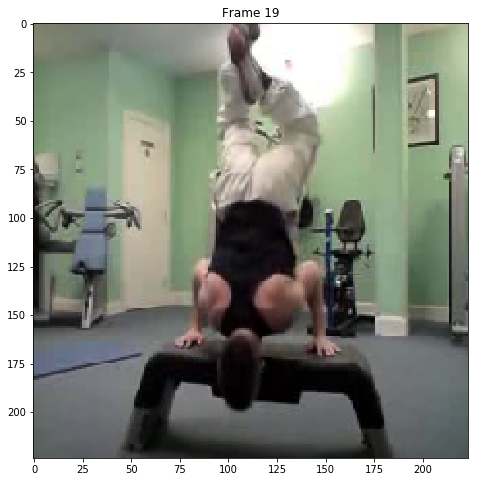

In [95]:
%matplotlib inline
import utils
utils.displayImageLoop(x[n])


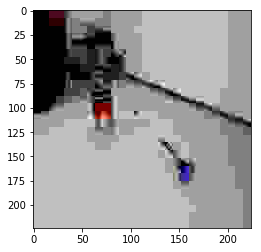

In [100]:
utils.displayImage(x[n][9])

In [23]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

In [52]:
d_class_weights

{0: 0.54, 1: 1.08, 2: 1.8, 3: 1.35, 4: 1.08}

In [55]:
def generate_sample_weights(training_data, class_weight_dictionary): 
    sample_weights = [class_weight_dictionary[np.where(one_hot_row==1)[0][0]] for one_hot_row in training_data]
    return np.asarray(sample_weights)

In [57]:
s_weights = generate_sample_weights(y, c_weights)

In [11]:
utils.nonNormalAccuracy(x,yseq,dataset,m)

(0.9144736842105263,
 {'normal': 0.9868421052631579,
  'insert': 0.8269230769230769,
  'blurred': 0.9,
  'black': 1.0,
  'compressed': 1.0})

# Screwing around with the shapes

In [1]:
import numpy as np
import cv2
import os

imagePath = os.path.join('data', 'sequences', 'train', 'black', 'v_BaseballPitch_g03_c02-0019.jpg')

img = cv2.imread(imagePath)

cv2.imshow('image', img)


# cv2.line(img, (0), (150,150), (255,255,255), 15)
# cv2.rectangle(img, (15,25), (200,150), (0,255,0), 5)
# cv2.circle(img, (100,63), 55, (0,0,255), -1)

# pts = np.array([[10,5],[20,30],[70,20],[50,10]], np.int32)
# #pts = pts.reshape((-1,1,2))
# cv2.polylines(img, [pts], True, (0,355,355), 3)

# cv2.imshow('image', img)


NameError: name 'O' is not defined

(240, 320, 3)


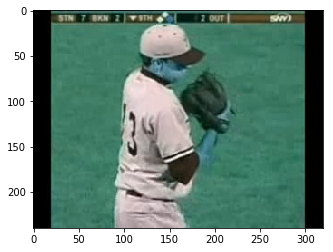

In [21]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
%matplotlib inline

imagePath = os.path.join('data', 'sequences', 'train', 'black', 'v_BaseballPitch_g03_c02-0019.jpg')

im = cv2.imread(imagePath, cv2.IMREAD_COLOR)
h,w = im.shape[:2]
print(im.shape)
plt.imshow(im)
plt.show()

# cv2.line(img, (0), (150,150), (255,255,255), 15)
# cv2.rectangle(img, (15,25), (200,150), (0,255,0), 5)
# cv2.circle(img, (100,63), 55, (0,0,255), -1)
# cv2.imshow('image',im)

# pts = np.array([[10,5],[20,30],[70,20],[50,10]], np.int32)
# #pts = pts.reshape((-1,1,2))
# cv2.polylines(img, [pts], True, (0,355,355), 3)

Box:  (109, 54, 162, 142)
Region:  <PIL.Image.Image image mode=RGB size=53x88 at 0x1CD94886DD8>


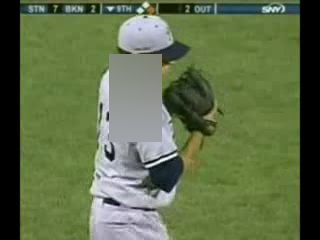

In [133]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFilter

imagePath = os.path.join('data', 'sequences', 'train', 'black', 'v_BaseballPitch_g03_c02-0019.jpg')
im = Image.open(imagePath)

imL = Image.open(imagePath).convert("L")


# box = (50, 100, 170, 200) #starting spots from (0,0)
xbox_start = np.random.randint(25, int(0.5*224))
ybox_start = np.random.randint(25, int(0.5*224))
xbox_end = np.random.randint(xbox_start+int(0.2*224), xbox_start+int(0.5*224))
ybox_end = np.random.randint(ybox_start+int(0.2*224), ybox_start+int(0.5*224))
box = (xbox_start, ybox_start, xbox_end, ybox_end)
print("Box: ", box)
region = im.crop(box)
# region
print('Region: ', region)

# region = region.transpose(Image.ROTATE_180)
# imArray = np.array(region)
# m = np.mean(imArray, axis=(0, 1)).astype('uint8')
# fullThing = np.full_like(imArray, m)
# region = Image.fromarray(fullThing)
region = region.filter(ImageFilter.GaussianBlur(radius=50))
im.paste(region, box)
im


# image.paste( (200,200,200), [0,0,image.size[0],image.size[1]])

In [90]:
imArray = np.array(region)
# imArray[0][0] #up/dow, left/right
imArray

array([[[124, 137, 105],
        [124, 137, 105],
        [124, 137, 105],
        ...,
        [105, 119,  83],
        [105, 119,  83],
        [105, 119,  83]],

       [[124, 136, 105],
        [124, 136, 105],
        [124, 136, 105],
        ...,
        [105, 119,  83],
        [105, 119,  83],
        [105, 118,  83]],

       [[124, 136, 105],
        [124, 136, 105],
        [124, 136, 105],
        ...,
        [105, 119,  83],
        [105, 119,  83],
        [105, 118,  83]],

       ...,

       [[123, 136, 106],
        [123, 136, 106],
        [123, 136, 105],
        ...,
        [101, 116,  80],
        [101, 115,  79],
        [101, 115,  79]],

       [[123, 136, 106],
        [123, 136, 106],
        [123, 136, 105],
        ...,
        [101, 116,  80],
        [101, 115,  79],
        [101, 115,  79]],

       [[123, 136, 106],
        [123, 136, 106],
        [123, 136, 105],
        ...,
        [101, 116,  80],
        [101, 115,  79],
        [101, 115,  79]]

In [55]:
m = np.mean(imArray, axis=(0, 1)).astype('uint8')
np.full_like(imArray, m)


array([[[132, 138, 135],
        [132, 138, 135],
        [132, 138, 135],
        ...,
        [132, 138, 135],
        [132, 138, 135],
        [132, 138, 135]],

       [[132, 138, 135],
        [132, 138, 135],
        [132, 138, 135],
        ...,
        [132, 138, 135],
        [132, 138, 135],
        [132, 138, 135]],

       [[132, 138, 135],
        [132, 138, 135],
        [132, 138, 135],
        ...,
        [132, 138, 135],
        [132, 138, 135],
        [132, 138, 135]],

       ...,

       [[132, 138, 135],
        [132, 138, 135],
        [132, 138, 135],
        ...,
        [132, 138, 135],
        [132, 138, 135],
        [132, 138, 135]],

       [[132, 138, 135],
        [132, 138, 135],
        [132, 138, 135],
        ...,
        [132, 138, 135],
        [132, 138, 135],
        [132, 138, 135]],

       [[132, 138, 135],
        [132, 138, 135],
        [132, 138, 135],
        ...,
        [132, 138, 135],
        [132, 138, 135],
        [132, 138, 135]]

In [75]:
xbox_start = np.random.randint(25, int(0.5*224))
ybox_start = np.random.randint(25, int(0.5*224))
xbox_end = np.random.randint(xbox_start, xbox_start + int(0.5*224))
ybox_end = np.random.randint(ybox_start, ybox_start + int(0.5*224))
box = (xbox_start, ybox_start, xbox_end, ybox_end)
box

(39, 44, 109, 110)

In [21]:
a = np.empty(20)
b = np.arange(0, 20, 1, 'int')
ind = np.arange(len(a))
np.put(a, ind, b)
print(a)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]


In [20]:
a[0]

0.0

In [31]:
np.random.shuffle(a)
a[0:4]

array([ 3.,  5., 17., 16.])

In [14]:
a.astype(int)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [15]:
a[0]

0.0

In [16]:
a[1]

1.0

In [54]:
num = 3
size = 6
dist = 1

x = (num*(size+dist) - dist)
print(x)

#num, size, dist -> this assumes we start at front
# 2, 9, 1
# 2, 9, 2
# 2, 8, 3
# 2, 8, 4
# 2, 7, 5
# 2, 7, 6
# 2, 6, 7
# 2, 6, 8
# 2, 5, 9
# 2, 5, 10

# 3, 

20
